In [82]:
!pip install opencv-contrib-python

     |████████████████████████████████| 57.4 MB 12.2 MB/s eta 0:00:01


# %matplotlib inline

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import seaborn as sns
import colorsys

from scripts import *
from sklearn.cluster import MiniBatchKMeans
from tqdm import tqdm

plt.rcParams['figure.figsize'] = 20, 5

In [21]:
def iterate_over_mask(img, mask):
    segments = np.unique(mask)
    
    for segment in segments:
        print(segment)
        yield segment, get_subimage(img, mask == segment)
        
def get_luminance_weighted_mask(img_hls, mask_function=get_rule_of_thirds_mask, mask_kwargs={}):
    mask = mask_function(img_hls, **mask_kwargs)

    replacements = {}
    for segment_idx, mask_subimg in iterate_over_mask(img_hls, mask):
        replacements[segment_idx] = np.median(mask_subimg[:,:,1])
        
    flat_mask = mask.flatten()
    return pd.Series(flat_mask).map(replacements).values.reshape(*mask.shape)

def get_subimage(img, mask):
    x = np.max(mask, 1).sum()
    y = np.max(mask, 0).sum()
    
    return np.moveaxis(np.stack(
        [np.extract(mask, img[:,:,0]).reshape(x, y)
        ,np.extract(mask, img[:,:,1]).reshape(x, y)
        ,np.extract(mask, img[:,:,2]).reshape(x, y)]
    ), 0, -1)

def sliding_grid():
    original_x_size, original_y_size = img.shape[:2]
    
    mask_matrix = np.zeros(img.shape[:2])
    
    cnt = 0
    x_steps = list(range(0, original_x_size, int(original_x_size/n))) + [original_x_size]
    y_steps = list(range(0, original_y_size, int(original_y_size/n))) + [original_y_size]
    for from_x, to_x in list(zip(x_steps, x_steps[1:]))[:n]:
        for from_y, to_y in list(zip(y_steps, y_steps[1:]))[:n]:            
            mask_matrix[from_x:to_x, from_y:to_y] = cnt
            cnt += 1
    
    return mask_matrix

def get_palette(hls_palette):
    paleta = list(map(lambda cl: colorsys.hls_to_rgb(cl[0], cl[1], cl[2]), hls_palette))
    
    return paleta

def get_color_wheel_quantized_img(fl_img_hls, color_wheel=np_itten_color_wheel, apply_sin_to_hue=True):
    fl_img_hls_n = fl_img_hls.copy()
    np_itten_color_wheel_n = np_itten_color_wheel.copy()

    if apply_sin_to_hue:
        fl_img_hls_n[:, :, 0] = np.sin(2*np.pi*fl_img_hls_n[:, :, 0])
        np_itten_color_wheel_n[:, 0] = np.sin(2*np.pi*np_itten_color_wheel_n[:, 0])
    
    distance = cdist(fl_img_hls.reshape(-1,3), color_wheel).reshape(fl_img_hls.shape[0], fl_img_hls.shape[1], color_wheel.shape[0])

    itten_img = np.argmin(distance, axis=2)
        
    return itten_img

def quantize_img(palette_index_matrix, palette=np_itten_color_wheel):
    shape = palette_index_matrix.shape
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

def quantize_img_color_wheel(img_hls, palette=np_itten_color_wheel):
    shape = img_hls.shape
    palette_index_matrix = get_color_wheel_quantized_img(img_hls, palette)
    
    return np.take(palette, palette_index_matrix.reshape(-1), axis=0).reshape(shape[0], shape[1], 3)

In [23]:
itten_color_wheel = [
 [53/360, 0.63, 0.94]
 ,[42/360, 0.51, 0.84]
 ,[32/360, 0.44, 0.97]
 ,[19/360, 0.40, 1.00 ]
 ,[349/360, 0.51, 0.40]
 ,[313/360, 0.32, 0.44]
 ,[268/360, 0.35, 0.68]
 ,[248/360, 0.49, 0.40]
 ,[233/360, 0.56, 0.64]
 ,[188/360, 0.32, 0.27]
 ,[130/360, 0.45, 0.22]
 ,[70/360, 0.49, 0.43]
]

other_ones = [
[240/460, 1, 0]
,[240/460, 0.5, 0]
,[240/460, 0, 0]
]

np_itten_color_wheel = np.array(itten_color_wheel)
np_wb_itten_color_wheel = np.array(itten_color_wheel + other_ones)


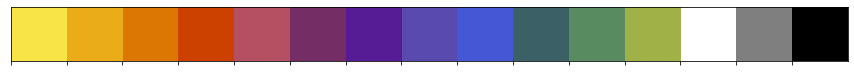

In [24]:
sns.palplot(get_palette(np_wb_itten_color_wheel))

# Carga archivos

In [25]:
cam = glob.glob('../../Osintgram/output/*.jpg')

In [29]:
img = cv2.imread(cam[0])

img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_hls = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HLS)


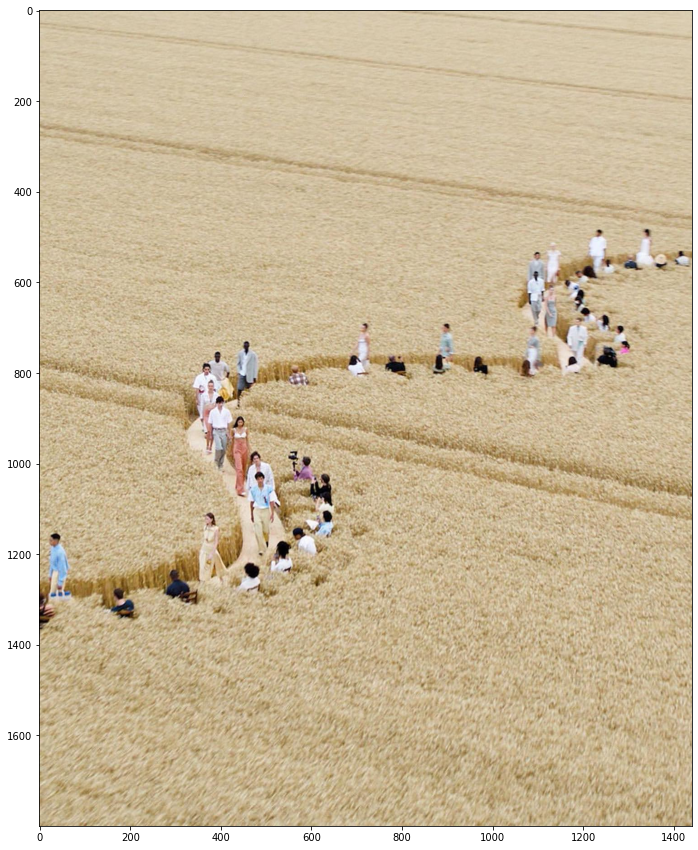

In [34]:
plt.figure(figsize=(20, 15))
plt.imshow(img_rgb)

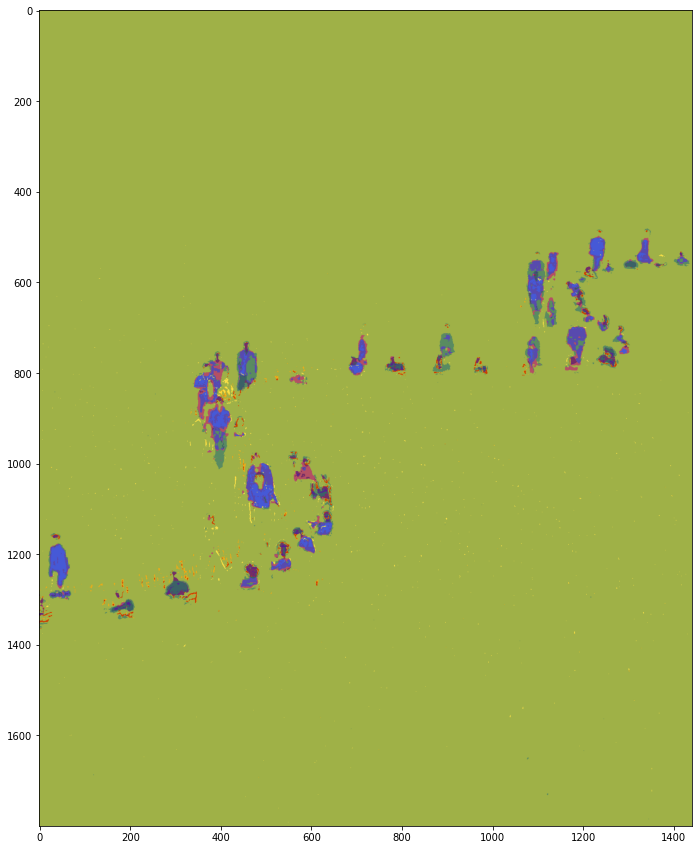

In [32]:
plt.figure(figsize=(20, 15))
plt.imshow(cv2.cvtColor(np.uint8(quantize_img_color_wheel(img_hls * (1/180, 1/255, 1/255), np_itten_color_wheel) * (180, 255, 255)), cv2.COLOR_HLS2RGB))